## Imports

In [1]:
import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import LambdaCallback
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import random

import datetime
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt

import wandb
from wandb.integration.keras import WandbMetricsLogger
wandb.login()

2024-06-09 10:31:07.015869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lana-caldarevic1. Use `wandb login --relogin` to force relogin


True

## Utils

In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# High-pass filter to remove baseline wander
def highpass_filter(data, cutoff=0.5, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Low-pass filter to remove high-frequency noise
def lowpass_filter(data, cutoff=40.0, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Notch filter to remove powerline interference
def notch_filter(data, cutoff=50.0, fs=250, quality_factor=30.0):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.iirnotch(normal_cutoff, quality_factor)
    y = signal.filtfilt(b, a, data)
    return y

def apply_filters_ecg(ecg_signal, fs):
    filtered_ecg = highpass_filter(ecg_signal, cutoff=0.5, fs=fs)
    filtered_ecg = lowpass_filter(filtered_ecg, cutoff=40.0, fs=fs)
    filtered_ecg = notch_filter(filtered_ecg, cutoff=50.0, fs=fs)
    return filtered_ecg

def apply_filters_resp(resp_signal, fs):
    filtered_resp = highpass_filter(resp_signal, cutoff=0.1, fs=fs)
    filtered_resp = lowpass_filter(filtered_resp, cutoff=2.0, fs=fs)
    filtered_resp = notch_filter(filtered_resp, cutoff=50.0, fs=fs)
    return filtered_resp

In [3]:
# plotting
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        ax.set_title(f'Example {i+1}')
    
    plt.tight_layout()
    plt.show()

In [4]:
# cross-correlation metric
def cross_correlation(y_true, y_pred):
    """ Compute cross-correlation between true and predicted signals. """
    y_true_mean = tf.reduce_mean(y_true, axis=1, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    
    y_true_std = tf.math.reduce_std(y_true, axis=1, keepdims=True)
    y_pred_std = tf.math.reduce_std(y_pred, axis=1, keepdims=True)

    norm_y_true = (y_true - y_true_mean) / y_true_std
    norm_y_pred = (y_pred - y_pred_mean) / y_pred_std

    correlation = tf.reduce_mean(norm_y_true * norm_y_pred, axis=1)
    return tf.reduce_mean(correlation)

## Data Loading - Fantasia

In [5]:
def load_fantasia():
    files = os.listdir("/home/lcaldarevic/workspace/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/home/lcaldarevic/workspace/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([apply_filters_ecg(data["ECG"], fs=250), apply_filters_resp(data["RESP"], fs=250)])

    return data_fantasia, patients_fantasia

In [6]:
data, patients = load_fantasia()

## Data Processing

In [7]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                normalized_ecg = (recrd_ecg - recrd_ecg.min()) / (recrd_ecg.max() - recrd_ecg.min())
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))

    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [8]:
train_val_patients, test_patients = train_test_split(patients, test_size=0.20, random_state=42)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.20, random_state=42)

In [9]:
len(train_patients), len(val_patients), len(test_patients)

(25, 7, 8)

(38021, 1024, 1)
(38021, 1024, 1)
(7173, 1024, 1)
(7173, 1024, 1)
(8870, 1024, 1)
(8870, 1024, 1)


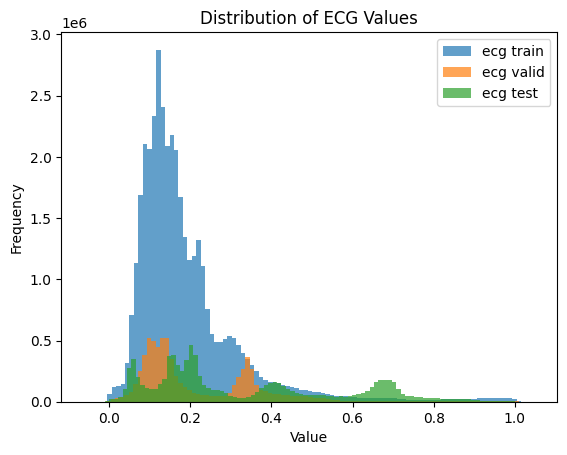

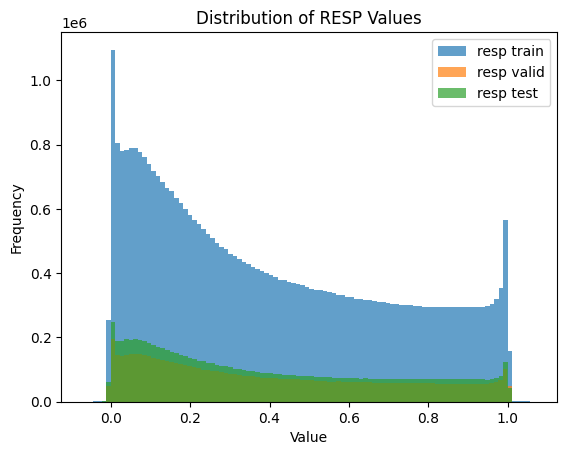

In [10]:
sampling_rate = 250
seconds_window = 8
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data, window_size, downsampled_window_size, test_patients)

plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Data Visualisation

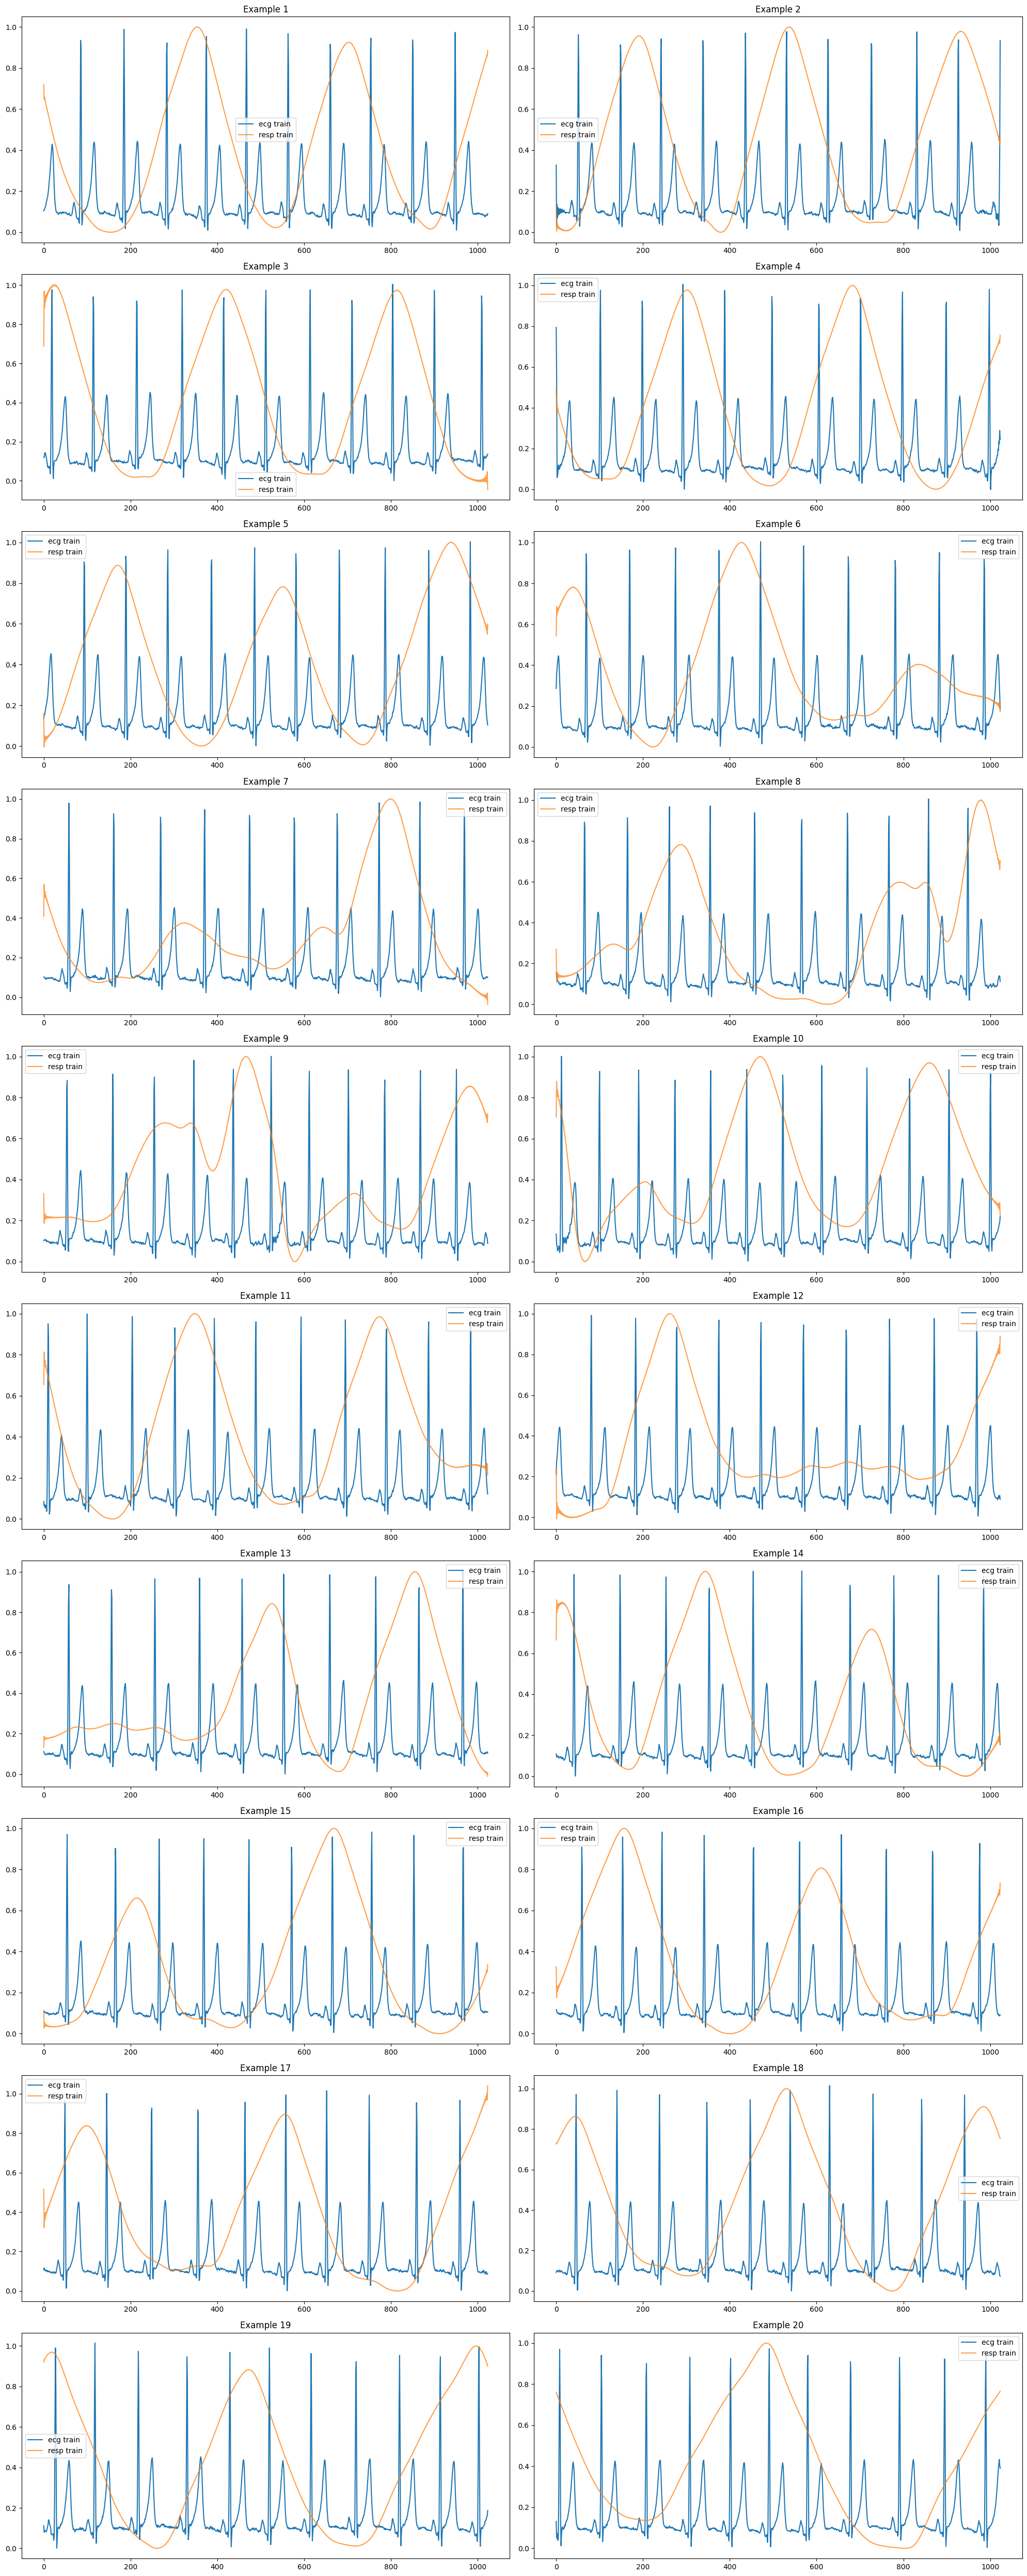

In [11]:
# train
plot_signals_in_grid(windows_ecg_train[0:20], windows_resp_train[0:20], labels=['ecg train', 'resp train'])

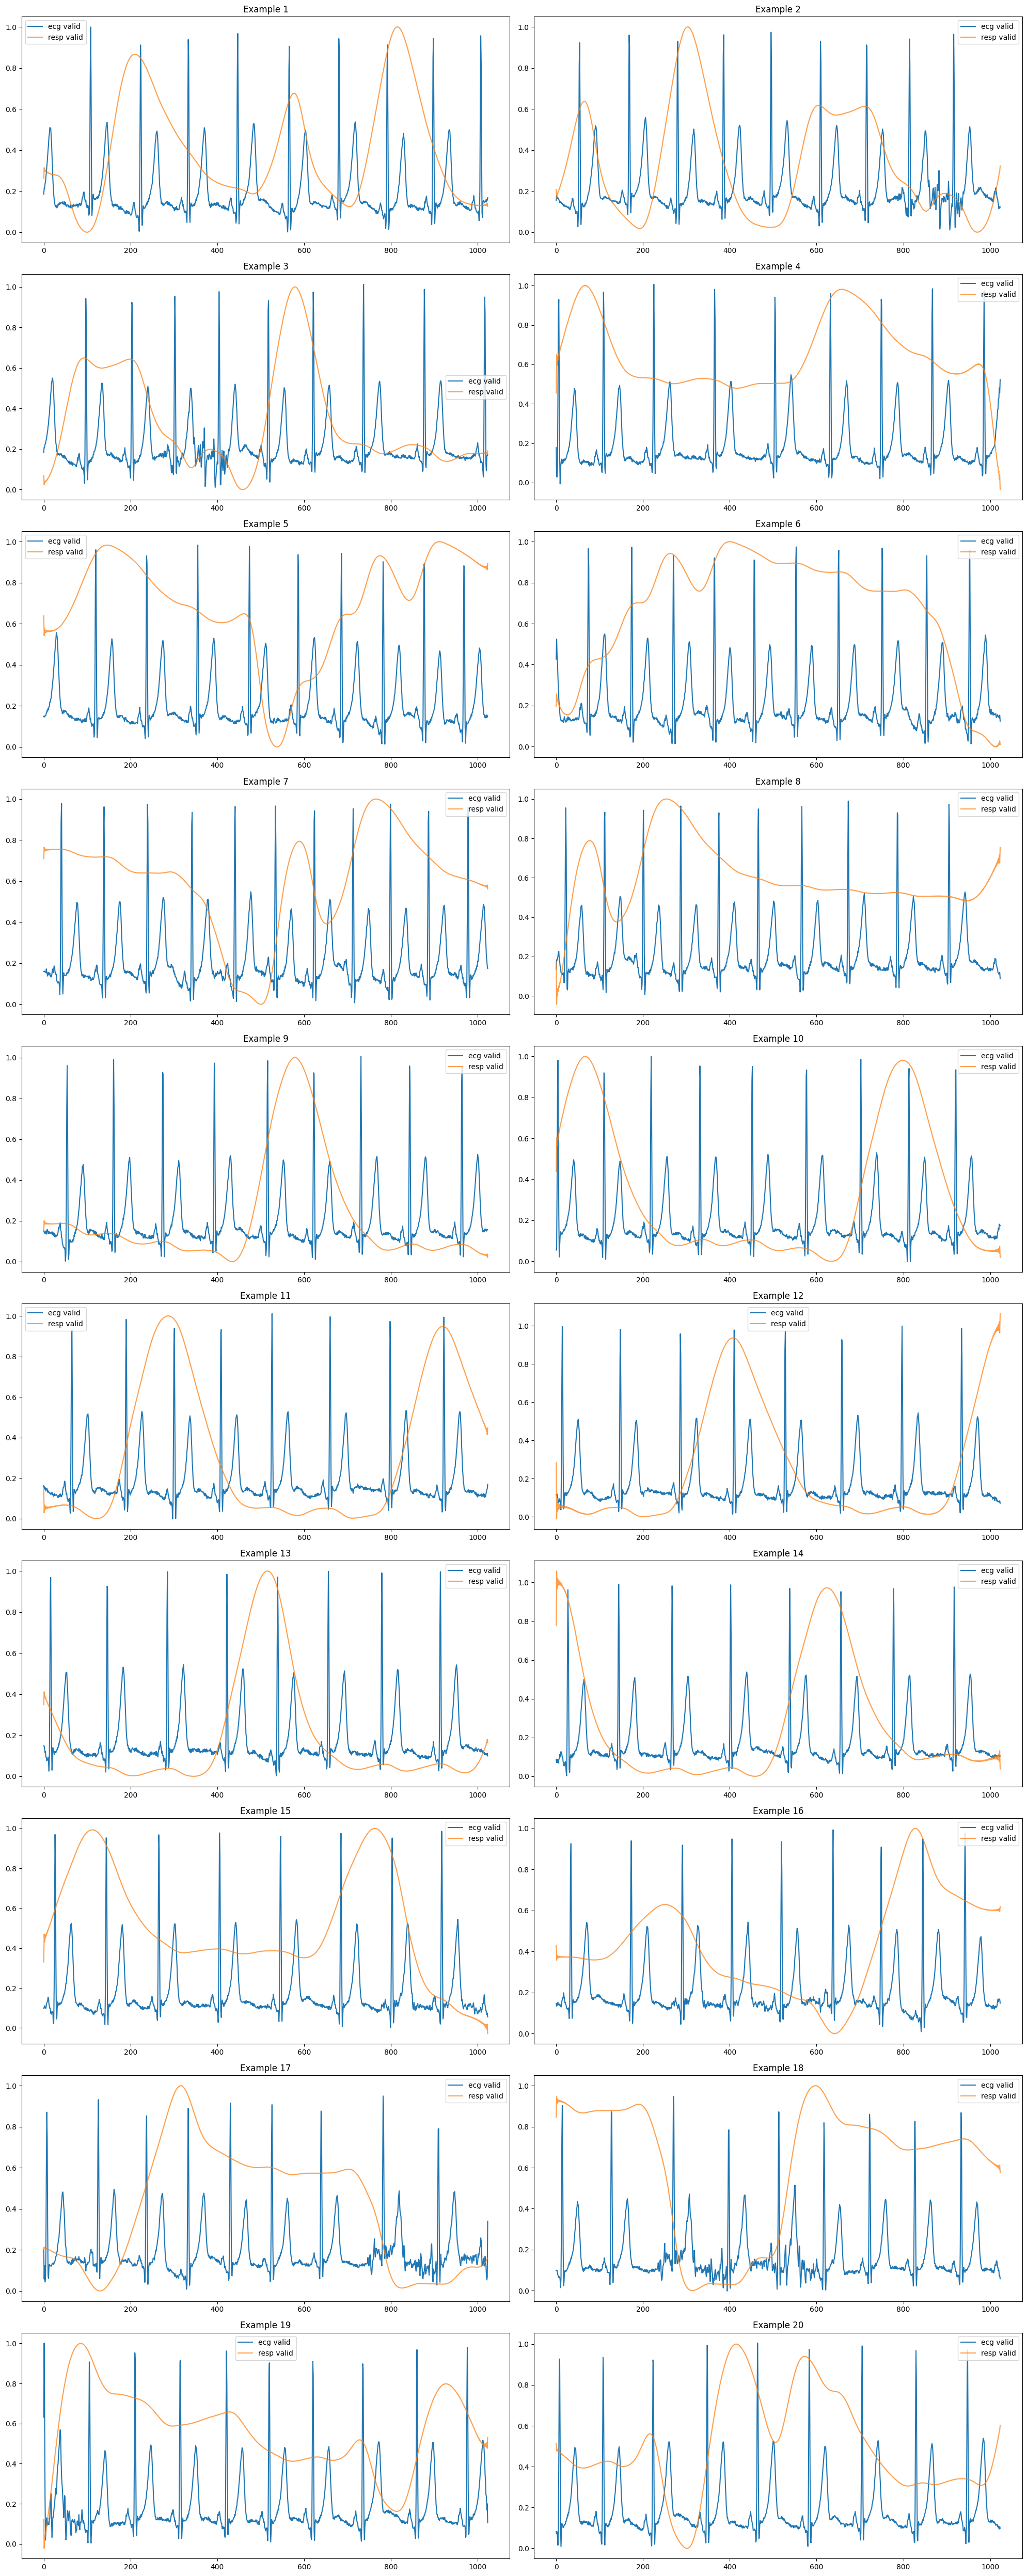

In [12]:
# valid
plot_signals_in_grid(windows_ecg_validation[0:20], windows_resp_validation[0:20], labels=['ecg valid', 'resp valid'])

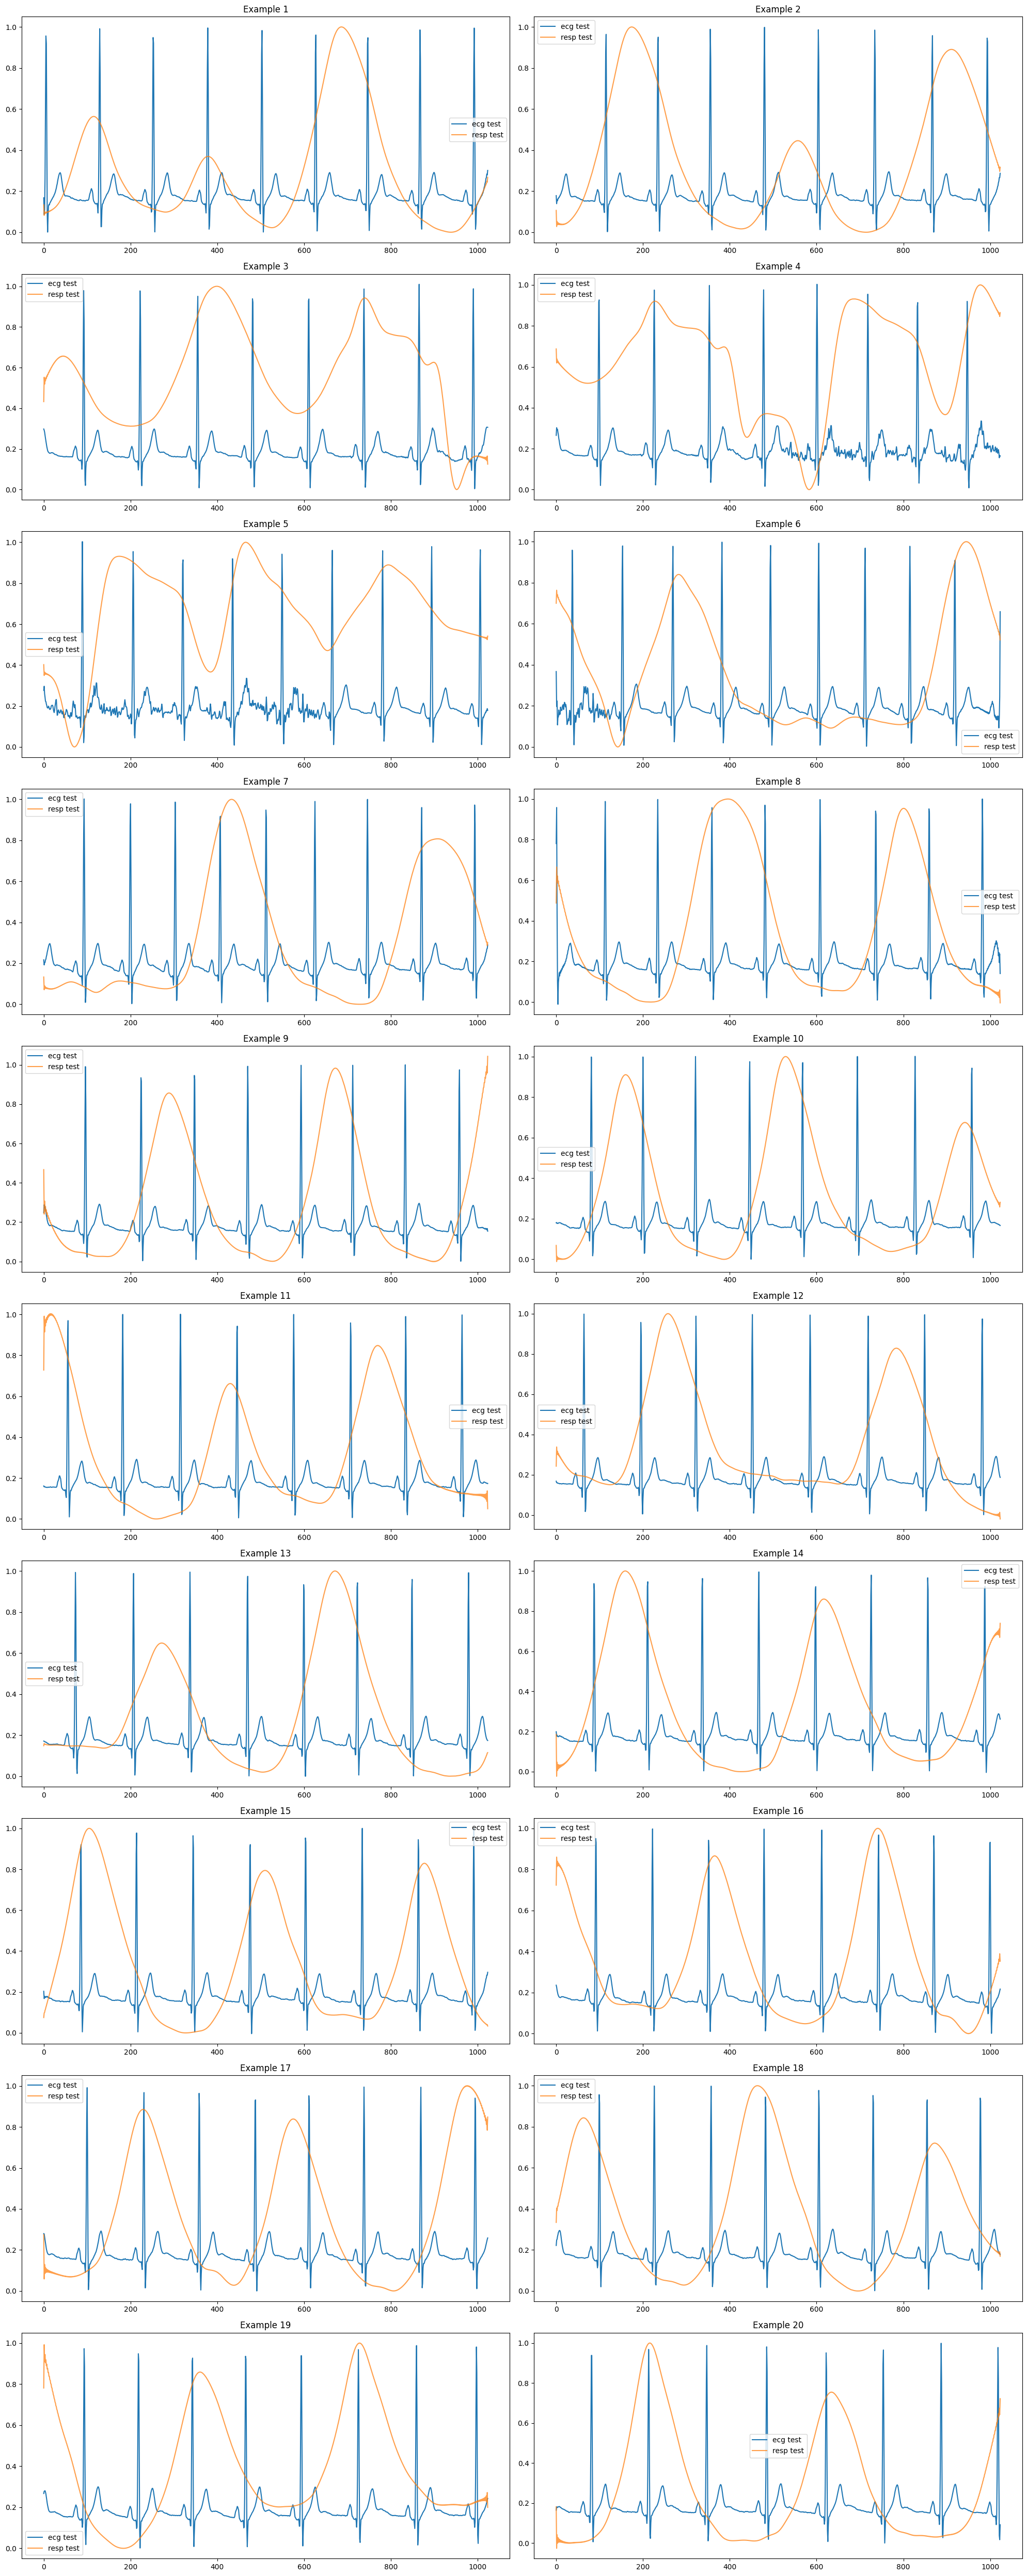

In [13]:
# test
plot_signals_in_grid(windows_ecg_test[0:20], windows_resp_test[0:20], labels=['ecg test', 'resp test'])

- too noisy?
- smoothing signal?
- performance metrics: add additional ones
- setup baseline with signal processing toolbox
- try arhitecture with different datasets

- P. H. Charlton, T. Bonnici, L. Tarassenko, D. A. Clifton, R. Beale, and
P. J. Watkinson, “An assessment of algorithms to estimate respiratory
rate from the electrocardiogram and photoplethysmogram,” Physiol.
Meas., vol. 37, pp. 610–626, 2016. -> check metrics

In [14]:
if tf.config.list_physical_devices('GPU'):
    print("GPU enabled")
    with tf.device('/GPU:0'):
        windows_ecg_train = tf.convert_to_tensor(windows_ecg_train, dtype=tf.float16)
        windows_resp_train = tf.convert_to_tensor(windows_resp_train, dtype=tf.float16)
        windows_ecg_validation = tf.convert_to_tensor(windows_ecg_validation, dtype=tf.float16)
        windows_resp_validation = tf.convert_to_tensor(windows_resp_validation, dtype=tf.float16)
        windows_ecg_test = tf.convert_to_tensor(windows_ecg_test, dtype=tf.float16)
        windows_resp_test = tf.convert_to_tensor(windows_resp_test, dtype=tf.float16)

GPU enabled


2024-06-09 10:31:35.206618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-06-09 10:31:35.207219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22198 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


## CNN Autoencoder

In [15]:
class ModelConfig:
    def __init__(self, kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, input_size, kernel_init):
        self.kernel_size = kernel_size
        self.reg = reg
        self.dropout = dropout
        self.start_filters = start_filters
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.input_size = input_size
        self.kernel_init = kernel_init

    def __getitem__(self, item):
        return getattr(self, item)

    def __setitem__(self, key, value):
        setattr(self, key, value)

In [16]:
def create_model(config):
    kernel_size = config['kernel_size']
    regularizer = regularizers.l2(config['reg'])
    dropout_rate = config['dropout']
    size_0 = config['start_filters']

    # Input layer
    in_data = layers.Input(shape=(config['input_size'], 1))

    # Encoder part
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(in_data)
    conv0 = layers.BatchNormalization()(conv0)
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(conv0)
    conv0 = layers.BatchNormalization()(conv0)
    pool0 = layers.MaxPooling1D(pool_size=2)(conv0)

    size_1 = size_0 * 2
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(pool0)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    size_2 = size_1 * 2
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Decoder part
    up1 = layers.UpSampling1D(size=2)(conv2)
    up_conv1 = layers.Conv1D(size_2, 2, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(up1)
    up_conv1 = layers.BatchNormalization()(up_conv1)
    merge1 = layers.concatenate([conv1, up_conv1], axis=2)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(merge1)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)

    up2 = layers.UpSampling1D(size=2)(conv3)
    up_conv2 = layers.Conv1D(size_1, 2, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(up2)
    up_conv2 = layers.BatchNormalization()(up_conv2)
    merge2 = layers.concatenate([conv0, up_conv2], axis=2)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(merge2)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer=config['kernel_init'])(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Output layer
    #out_data = layers.Conv1D(1, kernel_size, activation='sigmoid', padding='same')(conv4)
    out_data = layers.Conv1D(1, kernel_size, activation=None, padding='same')(conv4)

    model = models.Model(inputs=[in_data], outputs=[out_data])
    model.summary()

    return model

## Model tuning

In [17]:
"""
decreased batch size to 128 -> bad performance for cross correlation (got values 0.0 something) https://wandb.ai/lana-caldarevic1/fantasia-hp-tuning/sweeps/06i1j3gb?nw=nwuserlanacaldarevic1


"""

def create_sweep_config():
    return {
        'method': 'random',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                #'min': 1e-5,
                #'max': 1e-2
                'values': [0.00001]
            },
            'batch_size': {
                'values': [256]
            },
            'kernel_size': {
                'values': [27]
            },
            'reg': {
                'min': 1e-5,
                'max': 1e-2
            },
            'dropout': {
                'min': 0.1,
                'max': 0.6
            },
            'start_filters': {
                'values': [8]
            },
            'input_size': {
                'values': [1024]
            },
            'epochs': {
                'values': [200]
            },
            'kernel_init': {
                'values': ['he_normal', 'he_uniform']
            }
            
        }
    }

In [18]:
def train(config=None):
    if config:
        wandb.init(config=config)
    else:
        wandb.init()
        config = wandb.config

    lr = wandb.config.learning_rate
    optimizer = optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model = create_model(config)
    
    # define callbacks
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Metric to be monitored
    factor=0.1,            # Factor by which the learning rate will be reduced
    patience=10,           # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001         # Lower bound on the learning rate
    )
    #filepath = os.path.join('Users/lanacaldarevic/ecg_derived_resp_dl/models', f'model_crossval{split_ind}-size{start_filters}-input{input_size}_weights-improvement.h5')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    def log_representations_images(epoch, logs):
        wandb.log({"loss": logs['loss'],"CC": logs['cross_correlation'], "val_loss": logs['val_loss'], "val_CC": logs['val_cross_correlation']})
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Ground truth vs. Prediction')

        for row in range(2):
            train_idx = np.random.randint(0, windows_ecg_train.shape[0])
            val_idx = np.random.randint(0, windows_ecg_validation.shape[0])

            to_predict_train = np.array([windows_ecg_train[train_idx]])
            ground_truth_train = windows_resp_train[train_idx]
            prediction_train = model.predict(to_predict_train)[0]
            prediction_train_score = model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)

            to_predict_validation = np.array([windows_ecg_validation[val_idx]])
            ground_truth_validation = windows_resp_validation[val_idx]
            prediction_validation = model.predict(to_predict_validation)[0]
            prediction_validation_score = model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)

            ax[row, 0].plot(ground_truth_train, label='Ground Truth')
            ax[row, 0].plot(prediction_train, label='Prediction')
            ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f}")
            ax[row, 0].legend()

            ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
            ax[row, 1].plot(prediction_validation, label='Prediction')
            ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f}")
            ax[row, 1].legend()
    
        wandb.log({
            "predictions_visualization": wandb.Image(fig)
        }, commit=False)
        plt.close(fig)
    
    callbacks = [WandbMetricsLogger(),
                 LambdaCallback(on_epoch_end=log_representations_images),
                 #reduce_lr,
                 early_stopping
                ]
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)
    
    print("Model training starting")
    model.fit(windows_ecg_train, windows_resp_train,
              epochs=config['epochs'],
              batch_size=wandb.config.batch_size,
              shuffle=True,
              callbacks=callbacks,
              validation_data=(windows_ecg_validation, windows_resp_validation),
             verbose=0)
    
    wandb.finish()

    return model

In [ ]:
def train_simple(config):
    optimizer = tf.keras.optimizers.Adam()

    model = create_model(config)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    def lr_schedule(epoch, lr):
        new_lr = 1e-5 * (10 ** (epoch / 20))
        print(f"Learning Rate at epoch {epoch}: {new_lr}")
        return new_lr

    # Create a LearningRateScheduler callback
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
    
    callbacks = [
        lr_scheduler
    ]

    model.fit(
        windows_ecg_train, windows_resp_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(windows_ecg_validation, windows_resp_validation),
        callbacks=callbacks
    )
    return model

In [ ]:
sweep_config = create_sweep_config()
sweep_id = wandb.sweep(sweep_config, project="fantasia-hp-tuning")

wandb.agent(sweep_id, train)

In [21]:
"""
lr = 0.0016 
lr = 0.0009 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/9113b7uu?nw=nwuserlanacaldarevic1, less fluctuating, but still
lr = 0.00001 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/g1rmf8k9?nw=nwuserlanacaldarevic1
lr = 0.00099 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/d0l1evd9

reg = 0.00016
reg = 0.002 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/usl9prvf?nw=nwuserlanacaldarevic1

lr = 0.00001 reg = 0.002 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/vxzccom5?nw=nwuserlanacaldarevic1
lr = 0.00001 reg = 0.02 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/vauxk2z5?nw=nwuserlanacaldarevic1, 500 epochs: https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/7gdb6v68?nw=nwuserlanacaldarevic1 (THIS GOOD!)
1000 epochs: https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/tjrfhxcz?nw=nwuserlanacaldarevic1
lr = 0.00001 reg = 0.006 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/ypgl60qo?nw=nwuserlanacaldarevic1
lr = 3e-4 reg = 0.006 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/7rmps9wl?nw=nwuserlanacaldarevic1
lr = 3e-4 reg = 0.006 + reduce lr https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/6rw1mtb3?nw=nwuserlanacaldarevic1
lr = 3e-4 reg = 0.06 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/m33hbsjg
lr = 0.00001 reg = 0.02, epoch = 500, droput = 0.6 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/c3dq5bqo
lr = 0.00001 reg = 0.2, epoch = 500, droput = 0.6 https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/gasim5lz?nw=nwuserlanacaldarevic1
lr = 0.00001 reg = 0.003, epoch = 500, droput = 0.18 + early stopping https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/dhd9078e?nw=nwuserlanacaldarevic1
lr = 3e-4 reg = 0.003, epoch = 500, droput = 0.18 + early stopping https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/k28r3h7s?nw=nwuserlanacaldarevic1
lr = 0.00001 reg = 0.003, epoch = 500, droput = 0.2 + early stopping + he_uniform https://wandb.ai/lana-caldarevic1/ecg_derived_resp_dl-notebooks/runs/vaga3kjs?nw=nwuserlanacaldarevic1
"""

# model config
kernel_size = 27
reg = 0.003
learning_rate = 0.00001
dropout = 0.2
start_filters = 8
batch_size = 256
epochs = 500
kernel_init = 'he_uniform'

config = ModelConfig(kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, downsampled_window_size, kernel_init)

In [ ]:
model = train(config)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1024, 8)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 512, 16)   │      3,472 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 256, 16)   │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 256, 32)   │     13,856 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_2     │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 512, 32)   │      2,080 │ up_sampling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

Model training starting
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
model.evaluate(windows_ecg_validation, windows_resp_validation)

In [ ]:
model.evaluate(windows_ecg_train, windows_resp_train)

In [ ]:
plot_signals_in_grid(windows_resp_validation[0:50], predicted_resp[0:50], labels=['resp true', 'resp predicted'])